# 0. Importing Necessary Packages

In [1]:
# Printing the information of Python, IPython, OS, and the generation date.
%load_ext version_information
%version_information

Software versions
Python 3.7.9 64bit [GCC 7.3.0]
IPython 7.16.1
OS Linux 5.8.18 100.fc31.x86_64 x86_64 with fedora 31 Thirty_One
Sun May 08 22:15:13 2022 KST

In [23]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'astropy', 'pandas']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.21.0
matplotlib: ver 3.2.2
astropy: ver 4.2.1
pandas: ver 1.2.4


In [24]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import numpy as np
import glob, os
from matplotlib import pyplot as plt
from astropy.io import fits
import pandas as pd

# 1. Writing Input Files

### 1) Image list

In [6]:
dir_img = "Images/"
band = ["F606W", "F814W"]
imglist = sorted(glob.glob(dir_img+"*.fits"))
imglist

['Images/M0717_F606W.fits', 'Images/M0717_F814W.fits']

### 2) Configuration file

In [4]:
config_name = "config.txt"
os.system("sex -dd > "+config_name)

0

### 3) Output parameter file

In [5]:
param_name = "output.param"
f = open(param_name, "w")
f.write("X_IMAGE\n")    # Object position along x [pixel]
f.write("Y_IMAGE\n")    # Object position along y [pixel]
f.write("NUMBER\n")    # Object number
f.write("MAG_AUTO\n")    # Kron-like elliptical aperture magnitude [mag]
f.write("MAGERR_AUTO\n")    # RMS error for MAG_AUTO    [mag]
f.write("KRON_RADIUS\n")    # Kron apertures in units of A or B
f.write("BACKGROUND\n")    # Background at centroid position
f.write("ALPHA_J2000\n")    # Right ascension of object center (J2000)
f.write("DELTA_J2000\n")    # Declination of object center (J2000)
f.write("A_IMAGE\n")    # Along major axis
f.write("B_IMAGE\n")    # Along minor axis
f.write("THETA_IMAGE\n")    # Position angle
f.write("MU_MAX\n")    # Peak surface brightness above background
f.write("FLAGS\n")    # Extraction flags
f.write("FWHM_IMAGE\n")    # FWHM assuming a gaussian core
f.write("FLUX_RADIUS\n")    # Half-light radii
f.write("CLASS_STAR\n")    # Star/Galaxy classifier output
f.close()

### 4) Determining input parameters

In [9]:
h606 = fits.getheader(imglist[0])
h814 = fits.getheader(imglist[1])

In [33]:
# band = ["F606W", "F814W"]
cat_name = ["606.cat", "814.cat"]
detect_minarea = 5  # DETECT_MINAREA = 5 (default)
detect_thresh = 1.5  # DETECT_THRESH = 1.5 (default)
saturated = 100.0  # SATUR_LEVEL = 100.0 (depending on the image!)
mag0 = [-2.5*np.log10(h606['PHOTFLAM'])-5.0*np.log10(h606['PHOTPLAM'])-2.408,
        -2.5*np.log10(h814['PHOTFLAM'])-5.0*np.log10(h814['PHOTPLAM'])-2.408]
egain = [h606['CCDGAIN']*h606['EXPTIME'], h814['CCDGAIN']*h814['EXPTIME']]
# GAIN (effective gain) = gain*exptime (for c/s image) --> this parameter only affects the magnitude error value!
pixel_scale = 0.03  # arcsec/pixel
fwhm = [0.09, 0.09]  # For HST images, seeing FWHMs are typically 3 pixels (~ 0.09 arcsec).
# However, you can directly measure the FWHM value in your image using imexamine or etc.,
# because the FWHM value can also vary with image quality.
back_size = 32  # BACK_SIZE = 64 (default) --> 32 (revised)
# Smaller BACK_SIZE --> Can subtract more local background --> Can detect more sources
checkimg = ["606_aper.fits", "814_aper.fits"]  # CHECKIMAGE_NAME (apertures)
refimg = imglist[1]

### 5) Shell script for SExtractor photometry

In [35]:
scr_name = "sephot.sh"
f = open(scr_name, "w")
for i in np.arange(len(band)):
    
    # Reference image
    if (imglist[i] == refimg):
        txt = "sex "+imglist[i]+" -c config.txt -CATALOG_NAME "+cat_name[i]+" -PARAMETERS_NAME output.param "

    # Non-reference image
    else:
        txt = "sex "+refimg+","+imglist[i]+" -c config.txt -CATALOG_NAME "+cat_name[i]+" -PARAMETERS_NAME output.param "

    txt += f"-DETECT_MINAREA {detect_minarea:d} -DETECT_THRESH {detect_thresh:.1f} "
    txt += f"-FILTER_NAME /usr/share/sextractor/default.conv -SATUR_LEVEL {saturated:.1f} "
    txt += f"-MAG_ZEROPOINT {mag0[i]:.4f} -GAIN {egain[i]:.2f} -PIXEL_SCALE {pixel_scale:.2f} "
    txt += f"-SEEING_FWHM {fwhm[i]:.2f} -STARNNW_NAME /usr/share/sextractor/default.nnw -BACK_SIZE {back_size:d} "
    txt += "-CHECKIMAGE_TYPE APERTURES -CHECKIMAGE_NAME "+checkimg[i]
    txt += "\n"
    
    f.write(txt)
    
f.close()

# 2. Running SExtractor

In [36]:
os.system("sh sephot.sh")
# Run this and see the terminal where the Jupyter Notebook is open!

0

# 3. Reading the Data

In [65]:
colnames = ['x','y','num','mag','merr','kron','backgr','ra','dec',
            'a','b','theta','mu0','flag','fwhm','flxrad','cl']
dat_V = np.genfromtxt(cat_name[0], dtype=None, encoding='ascii', names=colnames)
dat_I = np.genfromtxt(cat_name[1], dtype=None, encoding='ascii', names=colnames)

In [66]:
pd.DataFrame(dat_V).head(5)

,x,y,num,mag,merr,kron,backgr,ra,dec,a,b,theta,mu0,flag,fwhm,flxrad,cl
0,1911.3966,731.6298,1,21.6796,0.0016,3.50,0.008239,109.418494,37.714342,19.341,17.623,0.44,20.1833,2,9.84,15.628,0.029
1,5889.4160,712.3062,2,25.0527,0.0258,5.07,0.000524,109.376589,37.714185,38.863,2.462,-79.74,24.3301,19,58.72,90.449,0.000
2,4584.9277,434.9285,3,21.8951,0.0017,3.50,0.004010,109.390331,37.711874,21.432,12.511,72.92,19.8551,0,13.37,10.840,0.029
3,2690.8933,337.5047,4,23.0958,0.0032,3.50,0.001310,109.410282,37.711060,15.863,6.663,-87.72,20.8277,0,8.63,9.864,0.029
4,1297.1003,281.1276,5,21.8859,0.0022,3.50,0.008271,109.424964,37.710586,33.888,13.639,-61.65,21.7182,0,111.26,27.440,0.001


In [67]:
pd.DataFrame(dat_I).head(5)

,x,y,num,mag,merr,kron,backgr,ra,dec,a,b,theta,mu0,flag,fwhm,flxrad,cl
0,1911.3966,731.6298,1,20.1743,0.0004,3.50,0.016663,109.418494,37.714342,19.341,17.623,0.44,18.7318,2,10.11,16.039,0.029
1,5889.4160,712.3062,2,24.5668,0.0140,5.07,0.000402,109.376589,37.714185,38.863,2.462,-79.74,23.9554,19,58.72,40.278,0.000
2,4584.9277,434.9285,3,20.5084,0.0004,3.50,0.007200,109.390331,37.711874,21.432,12.511,72.92,18.6067,0,13.36,12.136,0.029
3,2690.8933,337.5047,4,21.7658,0.0008,3.50,0.001527,109.410282,37.711060,15.863,6.663,-87.72,19.4696,0,8.54,9.882,0.029
4,1297.1003,281.1276,5,21.3095,0.0011,3.50,0.008162,109.424964,37.710586,33.888,13.639,-61.65,20.9812,0,73.93,26.175,0.029


# 4. Plotting the Figures

In [68]:
dat = [dat_V, dat_I]

### 1) Magnitude - magnitude error diagram

<IPython.core.display.Javascript object>


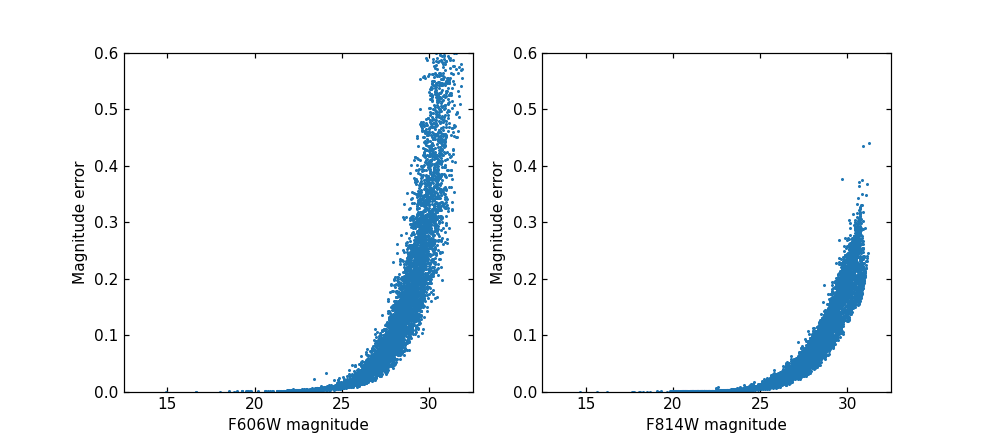

In [69]:
xlab = ["F606W magnitude", "F814W magnitude"]
ylab = ["Magnitude error"]

fig, axs = plt.subplots(1, 2, figsize=(9,4))
for i, ax in enumerate(axs):
    mag_range = (dat[i]['mag'] < 99.0)
    # magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
    ax.plot(dat[i]['mag'][mag_range], dat[i]['merr'][mag_range], 'o', ms=1)
    ax.set_xlim([12.5, 32.5])
    ax.set_ylim([0.0, 0.6])
    ax.set_xlabel(xlab[i])
    ax.set_ylabel(ylab[0])

### 2) Magnitude - stellarity (``CLASS_STAR``) digram

<IPython.core.display.Javascript object>


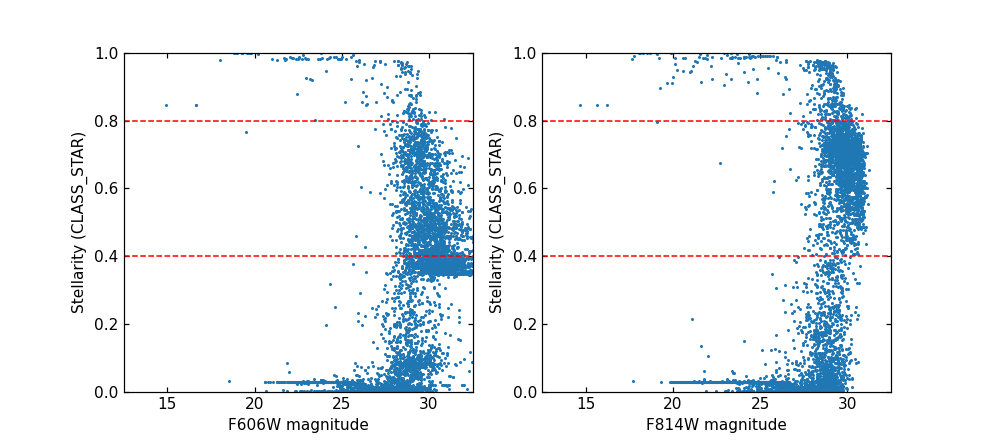

In [70]:
xlab = ["F606W magnitude", "F814W magnitude"]
ylab = ["Stellarity (CLASS_STAR)"]

fig, axs = plt.subplots(1, 2, figsize=(9,4))
for i, ax in enumerate(axs):
    mag_range = (dat[i]['mag'] < 99.0)
    # magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
    ax.plot(dat[i]['mag'][mag_range], dat[i]['cl'][mag_range], 'o', ms=1)
    ax.axhline(0.4, 0, 1, color='red', ls='--', lw=1)
    ax.axhline(0.8, 0, 1, color='red', ls='--', lw=1)
    # CLASS_STAR = 0.4 cut can also depend on the image quality, distribution of CLASS_STAR, or your scientific goals!
    ax.set_xlim([12.5, 32.5])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel(xlab[i])
    ax.set_ylabel(ylab[0])

### From the above basic results, how can you select point/extended sources for analysis?

### 3) CMDs of galaxies (just for example!)

<IPython.core.display.Javascript object>


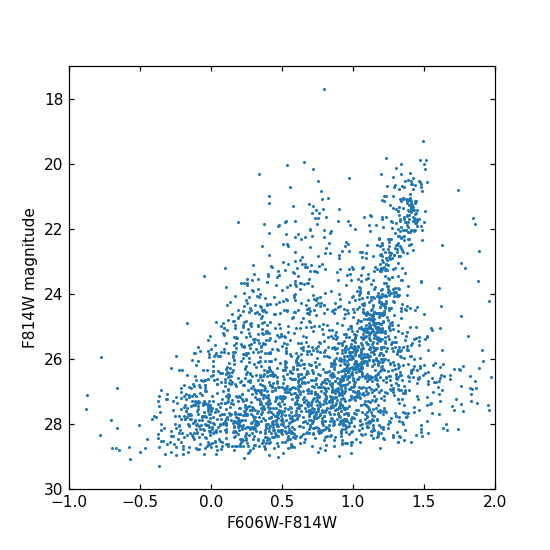

Text(0, 0.5, 'F814W magnitude')

In [78]:
gal_cnd = ((dat_V['mag'] < 30.0) & (dat_V['merr'] < 0.5) & (dat_I['mag'] < 30.0) & (dat_I['merr'] < 0.5) & \
           (dat_V['flxrad'] > 4.) & (dat_V['fwhm'] > 4.) & (dat_I['flxrad'] > 4.) & (dat_I['fwhm'] > 4.) & \
           (dat_V['mag']-dat_I['mag'] > -1.0) & (dat_V['mag']-dat_I['mag'] < 2.0) & \
           (dat_I['cl'] < 0.4))

xlab = ["F606W-F814W"]
ylab = ["F814W magnitude"]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(dat_V['mag'][gal_cnd]-dat_I['mag'][gal_cnd], dat_I['mag'][gal_cnd], 'o', ms=1)
# ax.axhline(0.4, 0, 1, color='red', ls='--', lw=1)
# # CLASS_STAR = 0.4 cut can also depend on the image quality, distribution of CLASS_STAR, or your scientific goals!
ax.set_xlim([-1.0, 2.0])
ax.set_ylim([30.0, 17.0])
ax.set_xlabel(xlab[0])
ax.set_ylabel(ylab[0])

### How about CMDs of point sources? or the sources of ``CLASS_STAR`` = 0.4 - 0.8? Do it yourself :)